# AI-Enhanced Emergency Response Pipeline


In [2]:
import whisper
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
# from deepspeech import Model as DeepSpeechModel
import textwrap


## Audio Transcription

In this stage we convert an emergency call recording into text using an automatic speech recognition (ASR) model.

- **OpenAI Whisper** – a state‑of‑the‑art ASR model trained on a large multilingual corpus. 


In [ ]:
audio_path = 'call2.mp3'
whisper_model = whisper.load_model('large', device="cuda")
result = whisper_model.transcribe(audio_path)


In [21]:
transcript = result['text']
print('Whisper transcript:')
print(textwrap.fill(transcript, width=100))

Whisper transcript:
 Brooke, 911, my husband's having a heart attack. Brooke, we're going to start CPR on him, okay? I'm
going to tell you what to do. Okay. Are you right next to him? Yeah. Put him flat on the floor on
his back. Okay. Expose his chest. Expose his chest. Kneel by his side. Okay. Okay. Okay. Put the
heel of your hand in the center of his chest right between the nipples. Okay. Push down firmly with
only the heels of your hand, two inches. Okay. And do it 30 times like you're pumping the chest. I'm
going to count. I want you to go this fast, as fast as I'm counting. Okay. One, two, three, four,
five, six, seven, eight, nine, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
27, 28, 29, 30. Start again. One, two, three, four, five, six, seven, eight, nine, 10, 11, 12, 13,
14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30. One, two, three, four, five,
six, seven, eight, nine, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2

## Clinical Summarisation

Once we have the raw transcript of the call, we summarise it into a concise clinical description using a biomedical language model. 
- **BioBART** (`GanjinZero/biobart-large`) – a BART‑based model fine‑tuned on radiology reports and other biomedical corpora.



In [7]:
model_name = "philschmid/flan-t5-base-samsum"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
summariser = pipeline('summarization', model=model, tokenizer=tokenizer)

sample_transcript = (transcript)
summary = summariser(sample_transcript, max_length=300, min_length=100, do_sample=False)

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=300) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [20]:
print('Summary:')
print(textwrap.fill(summary[0]['summary_text'], width=100))

Summary:
Brooke, 911, my husband's having a heart attack. Brooke's going to start CPR on him, okay? I'm going
to tell you what to do. I want you to go fast, as fast as you're counting. Okay. Are you right next
to him? Yeah. Put him flat on the floor on his back. Expose his chest. Kneel by his side. Put the
heel of your hand in the center of his chest right between the nipples. Push down firmly. Do it 30
times. The paramedic is taking over.


## Stroke Detection

In this stage we estimate the likelihood of a stroke based on speech characteristics :

**Speech‑based dysarthria detection:** Slurred or impaired speech is a hallmark of stroke.  We can extract acoustic features from the audio and train a classifier on a dysarthric speech dataset.

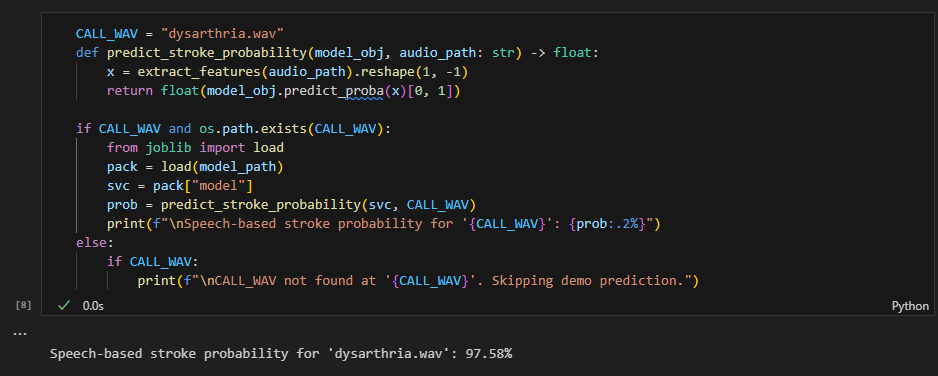

In [16]:
from IPython.display import Image, display
display(Image(filename="outputs/dysarthria_evaluation.png"))

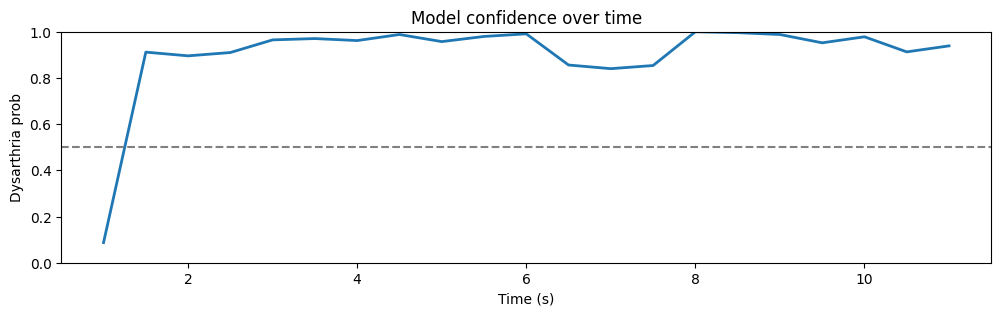

In [17]:
from IPython.display import Image, display
display(Image(filename="outputs/dysarthria_modelConfidence.png"))

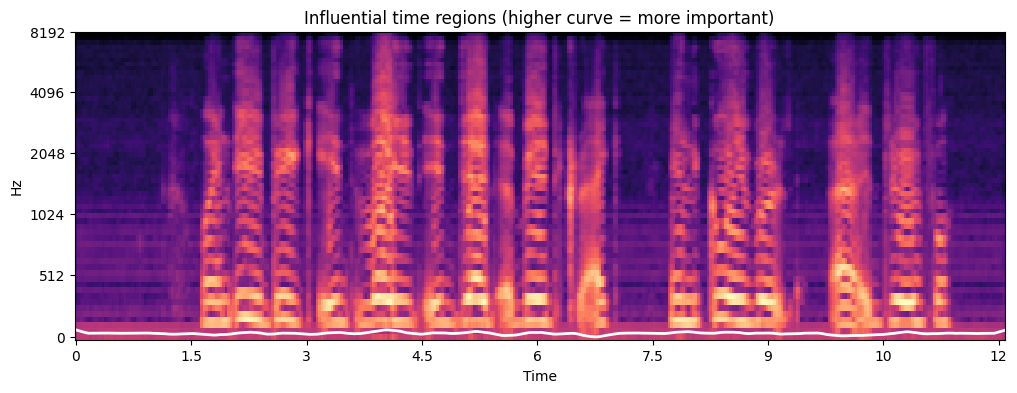

In [18]:
from IPython.display import Image, display
display(Image(filename="outputs/dysarthria_influentialTimeRegions.png"))

## Stroke Detection

In this stage we estimate the likelihood of a stroke based on vitals dats :

**Vitals‑based classification:** Using vital signs like blood pressure, heart rate and oxygen saturation, train a classifier to predict whether a patient has had a stroke.


###  SHAP Waterfall Plot (per-patient explanation)

- Breaks down one patient’s prediction.

- Red features push probability up (stroke risk).

- Blue features push it down.

**Insight**: Clinicians can see exactly which vitals and labs influenced a specific prediction.

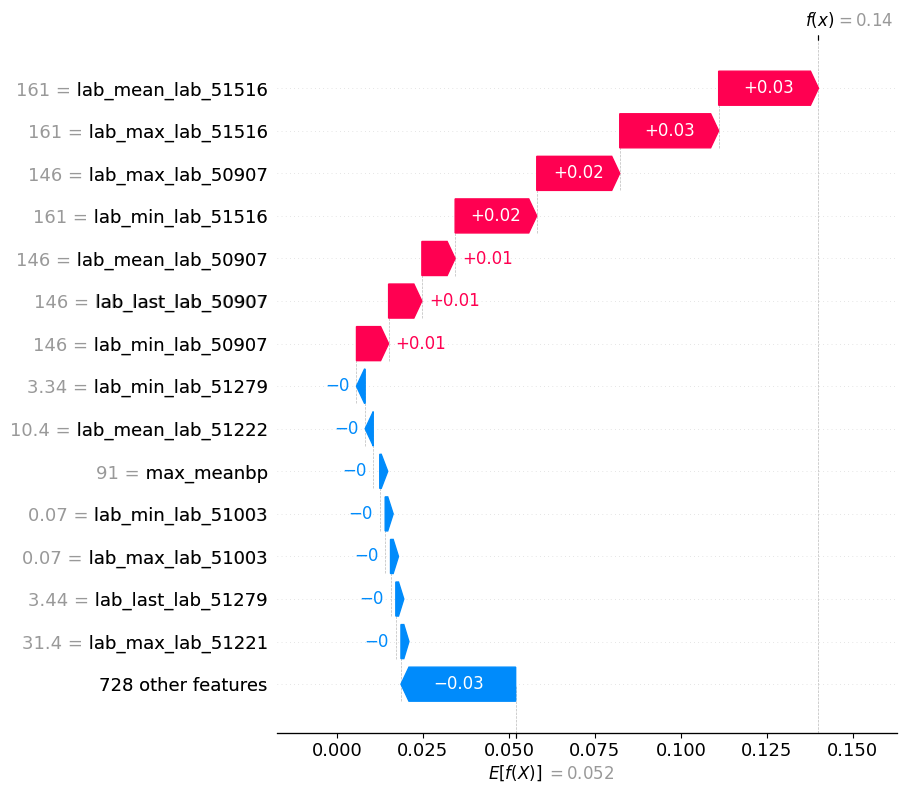

In [23]:
from IPython.display import Image, display
display(Image(filename="outputs/vitals_sHAP_patient.png"))

### SHAP Bar Plot (global)

- Aggregates the waterfall view over many patients.

- Confirms which features consistently raise or lower risk.

Useful for feature audit (check if medically meaningful or data quirks).

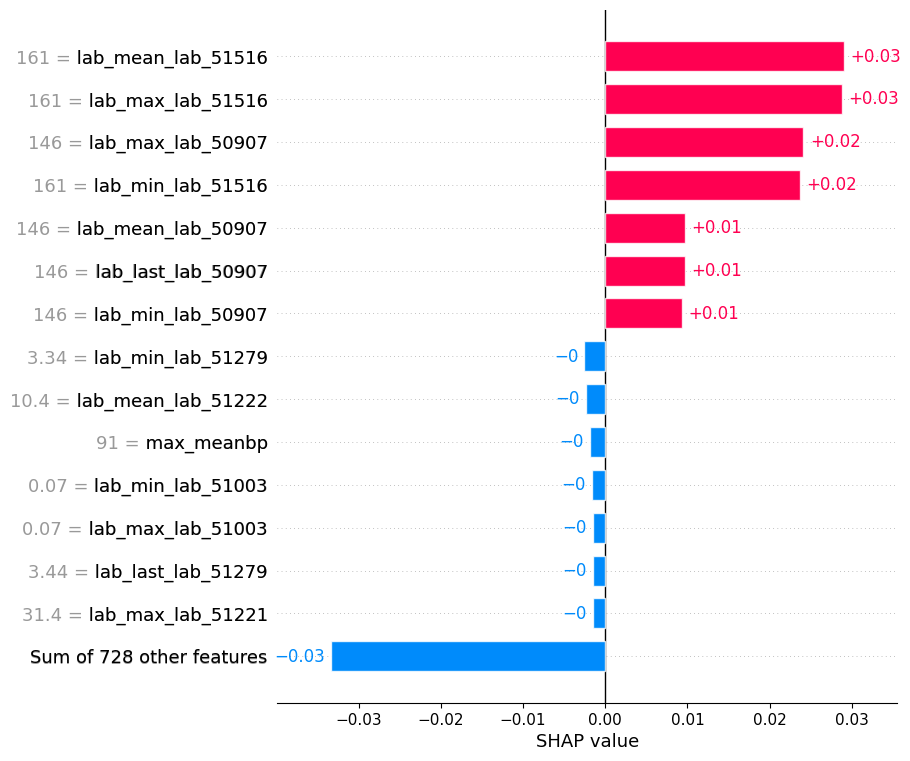

In [22]:
from IPython.display import Image, display
display(Image(filename="outputs/vitals_sHAP_many.png"))

## Timeline Generation

The final stage stitches together timestamped events from the call transcript, vital signs and interventions into an ordered timeline.  This helps clinicians visualise the patient’s journey from the first call to treatment.


In [19]:
# --- Timeline generation example ---
# Create sample event tables for call, vitals and interventions and merge them into an ordered timeline.

import pandas as pd

# Example call events
call_events = pd.DataFrame([
    {'time': '2025-08-13T12:30:45', 'event': '911 call received'},
    {'time': '2025-08-13T12:35:10', 'event': 'Ambulance dispatched'},
    {'time': '2025-08-13T12:50:00', 'event': 'Ambulance arrives'},
] )

# Example vital signs measurements
vital_events = pd.DataFrame([
    {'time': '2025-08-13T12:50:30', 'event': 'BP 180/95, HR 100, SPO2 93'},
    {'time': '2025-08-13T12:52:00', 'event': 'BP 185/100, HR 98, SPO2 90'},
] )

# Example interventions
intervention_events = pd.DataFrame([
    {'time': '2025-08-13T12:55:00', 'event': 'FAST exam positive'},
    {'time': '2025-08-13T13:10:00', 'event': 'Arrived at ER'},
] )

# Combine all events
events = pd.concat([call_events, vital_events, intervention_events])
events['time'] = pd.to_datetime(events['time'])
events = events.sort_values('time')

# Display timeline
for _, row in events.iterrows():
    print(f"{row['time'].strftime('%Y-%m-%d %H:%M:%S')} - {row['event']}")


2025-08-13 12:30:45 - 911 call received
2025-08-13 12:35:10 - Ambulance dispatched
2025-08-13 12:50:00 - Ambulance arrives
2025-08-13 12:50:30 - BP 180/95, HR 100, SPO2 93
2025-08-13 12:52:00 - BP 185/100, HR 98, SPO2 90
2025-08-13 12:55:00 - FAST exam positive
2025-08-13 13:10:00 - Arrived at ER
